In [1]:
import intake
import easygems.healpix as egh
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from datetime import datetime
import glob
import logging
import os
import pathlib
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})
import global3d_track as g3d
src = g3d.scripts.src

savedir = pathlib.Path('../../figures')
datadir = pathlib.Path(f'/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/')
os.makedirs(savedir, exist_ok=True)

In [2]:
dpi = 300
ext = 'pdf'

#### figure 1 - data snapshot

In [11]:
# load global

# time
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
d1 = cat.ICON.ngc4008(time="PT3H", zoom=9).to_dask().sel(time='20210704T2100')
d2 = cat.ICON.ngc4008a(time="PT15M", zoom=9).to_dask().sel(time=d1.time)

# area
ds = src.utils.regrid.Regrid((0,360,-90,90)).perform(d1[['clivi','cllvi']], zoom=9, resolution=0.1)
ds_amaz = src.utils.regrid.Regrid('amazon').perform(d2[['rlut',]], zoom=9, resolution=0.1)

INFO:root:Region to regrid: (0, 360, -90, 90)
INFO:root:Region to regrid: (-83, -43, -15, 15)


In [12]:
def alpha_cmap(cmap='Blues', rev=0):
    cmap_vals = plt.get_cmap(cmap)(np.linspace(0, 1.0, 256))
    cmap_vals[:, -1] = np.linspace(0.5, 1, 256) if not rev else np.linspace(0, 1, 256)[::-1]
    return mpl.colors.ListedColormap(cmap_vals)
    
def add_cbars(ax, cb0, cb1, cb2):
    cbar = fig.colorbar(cb1, ax=ax, orientation='vertical', pad=0)
    cbar.set_label("Specific ice [kg kg$^{-1}$]", fontsize=10)
    cbar = fig.colorbar(cb2, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label("Specific liquid [kg kg$^{-1}$]", fontsize=10)
    cbar = fig.colorbar(cb0, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label("Vertical velcoity [m s$^{-1}$]", fontsize=10)

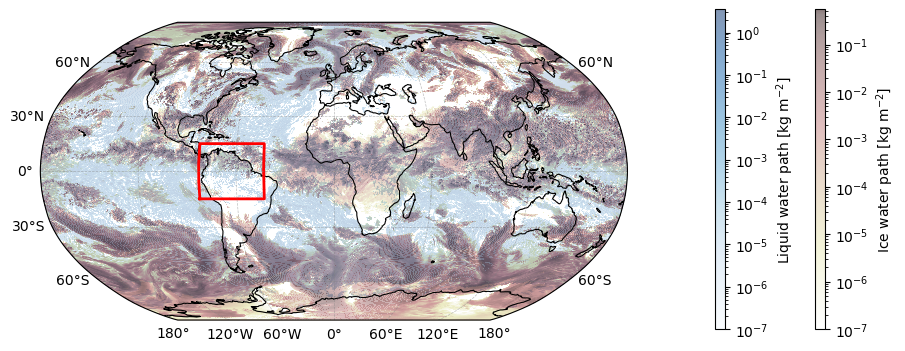

In [14]:
# prep

cmap_mask = mpl.colors.ListedColormap(plt.get_cmap('Reds')(np.linspace(0.25, 1, 100)))
levels = (1, 2, 3, 5, 10)
title_params = dict(fontsize=10)
extent = (ds.lon.min().item(), ds.lon.max().item(), -90, 90)
amz_extent = (ds_amaz.lon.min().item(), ds_amaz.lon.max().item(),
              ds_amaz.lat.min().item(), ds_amaz.lat.max().item())
fsize = 10

# fig
fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(1,2,width_ratios=[5,1])
ax1 = fig.add_subplot(gs[0], projection=ccrs.Robinson())

# plot 1
img1 = ds.cllvi.plot(ax=ax1, cmap='Blues', transform=ccrs.PlateCarree(), add_colorbar=False, norm=mpl.colors.LogNorm(), vmin=1e-7, alpha=.5, rasterized=True)
img2 = ds.clivi.plot(ax=ax1, cmap='pink_r', transform=ccrs.PlateCarree(), add_colorbar=False, norm=mpl.colors.LogNorm(), vmin=1e-7, alpha=.5, rasterized=True)

# add domain box
lon_min, lon_max, lat_min, lat_max = amz_extent
bbox_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
bbox_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax1.plot(bbox_lons, bbox_lats, transform=ccrs.PlateCarree(), color='r', linewidth=2)

# axes
# ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.coastlines(linewidth=0.8)
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax1.set_title(None)
ax1.set_title('', fontsize=fsize, loc='left')

# cbars
cax1 = fig.add_axes([0.8, 0.1, 0.01, 0.8])
cax2 = fig.add_axes([.9, 0.1, 0.01, 0.8])
cbar = fig.colorbar(img1, cax=cax1, orientation='vertical',)
cbar.set_label("Liquid water path [kg m$^{-2}$]", fontsize=10)
cbar = fig.colorbar(img2, cax=cax2, orientation='vertical',)
cbar.set_label("Ice water path [kg m$^{-2}$]", fontsize=10)

# fig
fig.savefig(savedir / f'fig01.{ext}', bbox_inches='tight', dpi=dpi)

#### figure 3 - vertical velocity histograms

In [6]:
# load histograms
workdir = datadir / 'w_histograms'

def load_wa_hist(name):
    wa = np.zeros(999)
    for f in (workdir).glob(f"{name}-*"):
        wa += np.load(f)
    wa_bins = np.load(next(workdir.glob("w500_histogram_bins*")))
    return wa, wa_bins

w500, wa_bins = load_wa_hist('w500_histogram')
cloudy, _ = load_wa_hist('w500_histogram_cloudy')
not_cloudy, _ = load_wa_hist('w500_histogram_not_cloudy')
arvo_very_cloudy, _ = load_wa_hist('w500_histogram_arvo_very_cloudy')
# not_very_cloudy, _ = load_wa_hist('w500_histogram_not_very_cloudy')


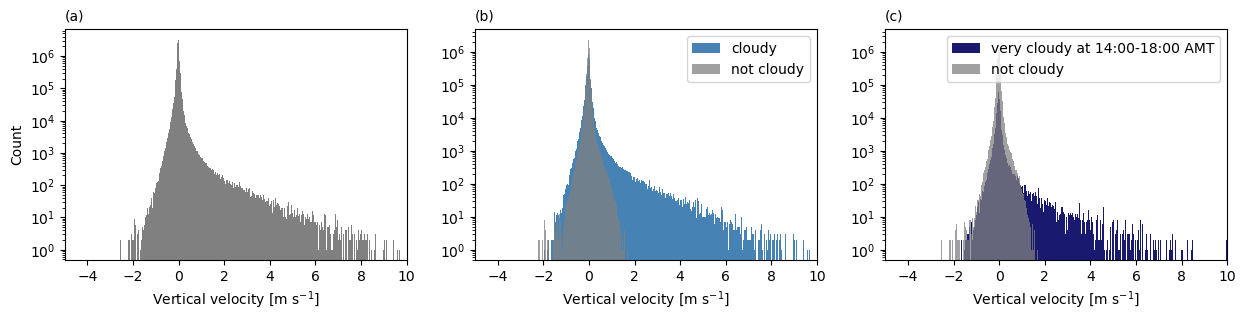

In [15]:
fs = 10
fig, axs = plt.subplots(1,3, figsize=(15,3))

ax = axs[0]
ax.bar(wa_bins[:-1], w500, width=np.diff(wa_bins), fc='grey')
ax.set(xlim=(-5,10))
ax.set_title('(a)', loc='left', fontsize=fs)
ax.set_ylabel('Count', fontsize=fs)
ax.set_xlabel('Vertical velocity [m s$^{-1}$]', fontsize=fs)
ax.set_yscale('log')

ax = axs[1]
# lab = '$q_i+q_l>$1e-5 kg kg$^{-3}$'
ax.bar(wa_bins[:-1], cloudy, width=np.diff(wa_bins), fc='steelblue', label='cloudy')
ax.bar(wa_bins[:-1], not_cloudy, width=np.diff(wa_bins), fc='grey', label='not cloudy', alpha=.75, )
ax.set(xlim=(-5,10))
ax.set_title('(b)', loc='left', fontsize=fs)
ax.set_xlabel('Vertical velocity [m s$^{-1}$]', fontsize=fs)
ax.set_yscale('log')
ax.legend()

ax = axs[2]
# lab = '$q_i+q_l>$1e-3 kg kg$^{-3}$''\n& 14:00-18:00 AMT'
ax.bar(wa_bins[:-1], arvo_very_cloudy, width=np.diff(wa_bins), fc='midnightblue', label='very cloudy at 14:00-18:00 AMT')
ax.bar(wa_bins[:-1], not_cloudy, width=np.diff(wa_bins), fc='grey', label='not cloudy', alpha=.75)
ax.set(xlim=(-5,10))
ax.set_title('(c)', loc='left', fontsize=fs)
ax.set_xlabel('Vertical velocity [m s$^{-1}$]', fontsize=fs)
ax.set_yscale('log')
ax.legend()

fig.savefig(savedir / f'fig03.{ext}', dpi=dpi, bbox_inches='tight')

#### figure 7 - what got tracked

In [13]:
# load data
area_ds = xr.open_mfdataset(datadir / 'what_got_tracked.nc')

In [15]:
# get vertical coords in height (m)
t_profile = xr.open_dataset(datadir / 'domain_mean_temperature_profile.nc')
area_ds = area_ds.assign_coords(dict(zg=t_profile.z_mean.sel(level_full=area_ds.level_full)))
area_ds = area_ds / 1e6 # to km^2

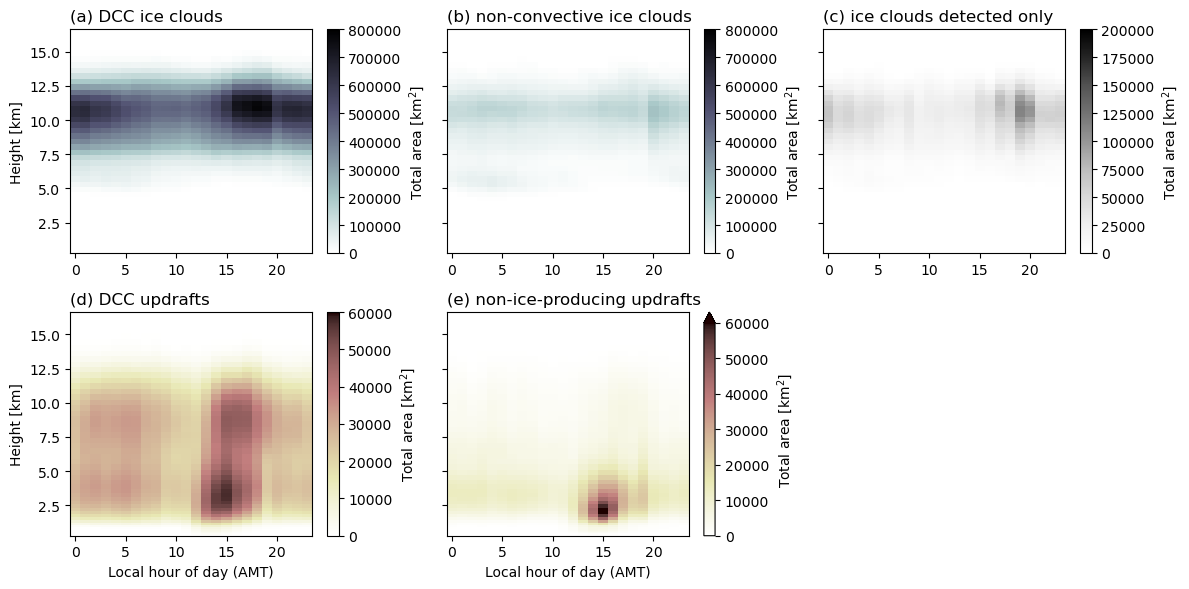

In [17]:
# plot
vmin_ice = 0
vmax_ice = 8e11 / 1e6
vmin_up = 0
vmax_up = 6e10 / 1e6

title_params = dict(loc='left', fontsize=12)

fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='tight', sharey=True)
top, bottom = axs

def plot_area(ax, data, vmin, vmax, title, cmap='Greys', cbar_kwargs={'label':'Total area [km$^2$]'}):
    im = data.plot(ax=ax, x='hour', y='zg', cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=1, cbar_kwargs=cbar_kwargs)
    ax.set_title(title, **title_params)
    return im

# --- ICE ---
plot_area(top[0], area_ds.dcc_ice, vmin_ice, vmax_ice, '(a) DCC ice clouds', cmap='bone_r')
plot_area(top[1], area_ds.tracked_ice - area_ds.dcc_ice , vmin_ice, vmax_ice, '(b) non-convective ice clouds', cmap='bone_r')
cbi = plot_area(top[2], area_ds.ice - area_ds.tracked_ice, vmin_ice, 2e11/1e6, '(c) ice clouds detected only', cmap='Greys')

# --- UPDRAFTS ---
plot_area(bottom[0], area_ds.dcc_updraft, vmin_up, vmax_up, '(d) DCC updrafts', cmap='pink_r')
cbw = plot_area(bottom[1], area_ds.tracked_updrafts - area_ds.dcc_updraft, vmin_up, vmax_up, '(e) non-ice-producing updrafts', cmap='pink_r')
bottom[2].axis('off')

# --- Axis labels ---
for ax in axs.flat:
    ax.set(title='', xlabel='', ylabel='')

for ax in bottom:
    ax.set_xlabel('Local hour of day (AMT)')

for ax in [top[0], bottom[0]]:
    ax.set_ylabel('Height [km]')

fig.savefig(savedir / f'fig07.{ext}', bbox_inches='tight', dpi=dpi)

#### figure 8 - tracking results overview

In [5]:
# load plot data

t1 = pd.to_datetime("2021-07-01T16:00")
t2 = pd.to_datetime("2021-07-02T04:00")

pds = xr.open_dataset(datadir / 'example_scenes.nc')
tdf = pd.read_csv(datadir / 'timeseries.csv', index_col='time')
tdf.index = pd.to_datetime(tdf.index)

# - validity
df = pd.read_csv(datadir / 'system_validity.csv', index_col='system_id')
invalid_convection = (df.n_cores_above_freezing / df.n_cores) == 1
invalid_rule = df.hits_boundary | invalid_convection
valid = df.index[~invalid_rule]

# - valid data
pds = pds.sel(system=valid)

In [6]:
# process for fig
footprint = (pds.att>0)
scaled_footprint = (footprint * pds.n_cores).max('system')
n_systems = tdf.loc[[t1,t2]].n_dccs

In [7]:
# plot prep

iwp_cmap = plt.get_cmap('Blues')
dcc_cmap = mpl.colors.ListedColormap(plt.get_cmap('Reds')(np.linspace(0.5, 1, 100)))
levels = (1, 2, 3, 5, 10)
title_params = dict(fontsize=12)
extent = (pds.lon.min().item(), pds.lon.max().item(),
          pds.lat.min().item(), pds.lat.max().item())

def plot_snapshot(ax, data, t, title=None, cmap=iwp_cmap, params={'cmap':iwp_cmap, }, setup=1):
    # Plot IWP
    img = data.sel(time=t).plot(ax=ax, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree(), add_colorbar=0, vmin=1e-4, **params)
    
    # Plot mask contours
    if setup:
        d = scaled_footprint.sel(time=t)
        cs = d.plot.contour(ax=ax, levels=levels, cmap=dcc_cmap, transform=ccrs.PlateCarree(), linewidths=1.5)
        
        # Axes setup
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.8)
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}
        
        # title
        t_str = d.time.dt.strftime('%b-%d %H:%M UTC').item()
        n_clouds = n_systems[t]
        title_str = title % n_clouds if title else f'{t_str}: {n_clouds:3d} clouds'
        ax.set_title(title_str, loc='left', **title_params)

        return cs, img
    else:
        return _, img

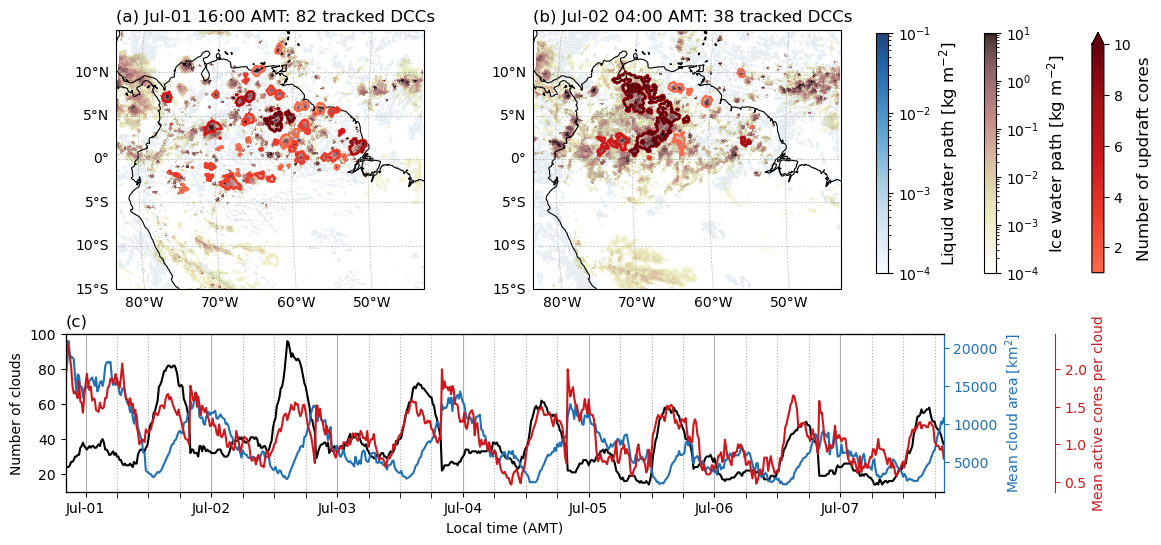

In [8]:
# fig
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(14,18, figure=fig)
ax1 = fig.add_subplot(gs[0:8,0:8], projection=ccrs.Robinson())
ax2 = fig.add_subplot(gs[0:8,8:16], projection=ccrs.Robinson())
ax3 = fig.add_subplot(gs[9:,:17])

# 1. plot top
_, _ = plot_snapshot(ax1, pds.lwp, t1, f"(a) {t1.strftime('%b-%d')} 16:00 AMT: %s tracked DCCs", params=dict(cmap='Blues', alpha=.9, vmax=.1))
_, _ = plot_snapshot(ax1, pds.iwp, t1, f"(b) {t1.strftime('%b-%d')} 04:00 AMT: %s tracked DCCs", params=dict(cmap='pink_r', alpha=.9, vmax=1e1), setup=0)
cs1, img1 = plot_snapshot(ax2, pds.lwp, t2, f"(b) {t2.strftime('%b-%d')} 04:00 AMT: %s tracked DCCs", params=dict(cmap='Blues', alpha=.9, vmax=.1))
cs2, img2 = plot_snapshot(ax2, pds.iwp, t2, f"(b) {t2.strftime('%b-%d')} 04:00 AMT: %s tracked DCCs", params=dict(cmap='pink_r', alpha=.9, vmax=1e1), setup=0)

# cbar 1
h, w = 0.4, 0.01
cax = fig.add_axes([0.89, 0.475, w, h])
cb = fig.colorbar(img2, cax=cax)
cb.ax.set_ylabel('Ice water path [kg m$^{-2}$]', **title_params)
cb.ax.tick_params(labelsize=10)

# cbar 2
cax = fig.add_axes([0.8, 0.475, w, h])
cb = fig.colorbar(img1, cax=cax)
cb.ax.set_ylabel('Liquid water path [kg m$^{-2}$]', **title_params)
cb.ax.tick_params(labelsize=10)

# cbar 3
cax = fig.add_axes([0.98, 0.475, w, h])
norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
sm = plt.cm.ScalarMappable(norm=norm, cmap=dcc_cmap)
cb = fig.colorbar(sm, cax=cax, extend='max')
cb.ax.set_ylabel('Number of updraft cores', **title_params)
cb.ax.tick_params(labelsize=10)

for ax in (ax1,ax2):
    ax.set(title='')

# 2. plot bottom
# prep
fsize=10
ax = ax3
c1 = plt.get_cmap('Blues')(.75)
c2 = plt.get_cmap('Reds')(.75)
axt = ax.twinx()
axt2 = ax.twinx()
src.utils.analysis_tools.color_axis(axt, color=c1, pad=0)
src.utils.analysis_tools.color_axis(axt2, color=c2, pad=80)

# data
ax.plot(tdf.index, tdf.n_dccs,  color='k', ls='-')
axt.plot(tdf.index, tdf.mean_dcc_area, color=c1, ls='-')
axt2.plot(tdf.index, tdf.n_cores_per_dcc, color=c2, ls='-')

# format
ax.set_ylabel('Number of clouds', fontsize=fsize, color='k')
ax.tick_params(axis='y', labelcolor='k', labelsize=fsize)
ax.tick_params(axis='x', labelsize=fsize)
ax.set_xlabel('Local time (AMT)', fontsize=fsize)
axt.set_ylabel(r'Mean cloud area [km$^2$]', fontsize=fsize, color=c1)
axt2.set_ylabel(r'Mean active cores per cloud', fontsize=fsize, color=c2)
axt.tick_params(axis='y', labelcolor=c1, labelsize=fsize)

# xaxis
mdates = mpl.dates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1, tz=None))
ax.set_xlim(tdf.index.min(), tdf.index.max())
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0,6,12,18]))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0,6,12,18]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

ax.tick_params(axis='x', which='major', labelsize=fsize)
ax.tick_params(axis='x', which='minor', length=4)

ax.grid(axis='x', which='minor', ls=':')
ax.grid(axis='x', which='major')

# Titles and grid
ax.set_title('(c)', loc='left', **title_params)

# fig
fig.subplots_adjust(hspace=0.5)
fig.savefig(savedir / f'fig08.{ext}', bbox_inches='tight', dpi=dpi)